In [1]:
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Importing item.csv dataset

In [2]:
item = pd.read_csv('./amazon-items.csv')
item.head()

,asin,brand,title,url,image,rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.00,0.0
1,B0009N5L7K,Motorola,Motorola I265 phone,https://www.amazon.com/Motorola-i265-I265-phon...,https://m.media-amazon.com/images/I/419WBAVDAR...,3.0,https://www.amazon.com/product-reviews/B0009N5L7K,7,49.95,0.0
2,B000SKTZ0S,Motorola,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...,https://www.amazon.com/MOTOROLA-C168i-CINGULAR...,https://m.media-amazon.com/images/I/71b+q3ydkI...,2.7,https://www.amazon.com/product-reviews/B000SKTZ0S,22,99.99,0.0
3,B001AO4OUC,Motorola,Motorola i335 Cell Phone Boost Mobile,https://www.amazon.com/Motorola-i335-Phone-Boo...,https://m.media-amazon.com/images/I/710UO8gdT+...,3.3,https://www.amazon.com/product-reviews/B001AO4OUC,21,0.00,0.0
4,B001DCJAJG,Motorola,Motorola V365 no contract cellular phone AT&T,https://www.amazon.com/Motorola-V365-contract-...,https://m.media-amazon.com/images/I/61LYNCVrrK...,3.1,https://www.amazon.com/product-reviews/B001DCJAJG,12,149.99,0.0


#### Importing reviews.csv dataset

In [3]:
review = pd.read_csv('./amazon-reviews.csv')
review.head()

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


#### Merging the two dataset

In [4]:
df = pd.merge(review, item, how="left", left_on="asin", right_on="asin")

In [5]:
df.rename(columns={"rating_x": "rating", "title_x": "title", "title_y": "item_title", "rating_y": "overall_rating"}, inplace=True)
df.head(100)

,asin,name,rating,date,verified,title,body,helpfulVotes,brand,item_title,url,image,overall_rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,B0029F2O3A,n. country boy,4,"October 6, 2010",False,never had a problem,never had a problem have had this phone for ov...,NaN,Samsung,"Samsung Alias2 U750 Phone, Black (Verizon Wire...",https://www.amazon.com/Samsung-Alias2-Phone-Ve...,https://m.media-amazon.com/images/I/41HWHpfPlM...,3.0,https://www.amazon.com/product-reviews/B0029F2O3A,29,0.0,0.0
96,B0029F2O3A,Kyle Griswold,1,"October 29, 2009",False,Terrible,Has some real ram issues. It is really unusabl...,2.0,Samsung,"Samsung Alias2 U750 Phone, Black (Verizon Wire...",https://www.amazon.com/Samsung-Alias2-Phone-Ve...,https://m.media-amazon.com/images/I/41HWHpfPlM...,3.0,https://www.amazon.com/product-reviews/B0029F2O3A,29,0.0,0.0
97,B0029F2O3A,Seth B. Tropinsky,5,"July 27, 2009",False,Wonderful innovative keypad,"Great phone, which has the comfort of a larger...",2.0,Samsung,"Samsung Alias2 U750 Phone, Black (Verizon Wire...",https://www.amazon.com/Samsung-Alias2-Phone-Ve...,https://m.media-amazon.com/images/I/41HWHpfPlM...,3.0,https://www.amazon.com/product-reviews/B0029F2O3A,29,0.0,0.0
98,B0029F2O3A,A-la Dawn,5,"March 30, 2011",False,Best fone ever!!!,"I have had this fone for two years, and have n...",1.0,Samsung,"Samsung Alias2 U750 Phone, Black (Verizon Wire...",https://www.amazon.com/Samsung-Alias2-Phone-Ve...,https://m.media-amazon.com/images/I/41HWHpfPlM...,3.0,https://www.amazon.com/product-reviews/B0029F2O3A,29,0.0,0.0


In [6]:
print("The dataset contains {0[0]: .0f} rows and {0[1]: .0f} variables.".format(df.shape))
df.head()

The dataset contains  67986 rows and  17 variables.


,asin,name,rating,date,verified,title,body,helpfulVotes,brand,item_title,url,image,overall_rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0


#### Checking the null values

In [7]:
df.isnull().sum()

asin                  0
name                  2
rating                0
date                  0
verified              0
title                14
body                 21
helpfulVotes      40771
brand               200
item_title            0
url                   0
image                 0
overall_rating        0
reviewUrl             0
totalReviews          0
price                 0
originalPrice         0
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.isnull().sum()

asin              0
name              0
rating            0
date              0
verified          0
title             0
body              0
helpfulVotes      0
brand             0
item_title        0
url               0
image             0
overall_rating    0
reviewUrl         0
totalReviews      0
price             0
originalPrice     0
dtype: int64

#### Removing all unnecessary columns

In [10]:
data = df.copy()
data = data[['asin', 'brand', 'rating', 'date', 'totalReviews', 'overall_rating', 'item_title', 'body']]
data.head(10)

,asin,brand,rating,date,totalReviews,overall_rating,item_title,body
43,B001AO4OUC,Motorola,4,"May 12, 2009",21,3.3,Motorola i335 Cell Phone Boost Mobile,This phone isn't kidding when it says military...
44,B001AO4OUC,Motorola,1,"November 19, 2012",21,3.3,Motorola i335 Cell Phone Boost Mobile,I bought this phone and found out IDEN phones ...
49,B001AO4OUC,Motorola,4,"November 25, 2012",21,3.3,Motorola i335 Cell Phone Boost Mobile,PHONE DID NOT COME WITH A SIM CARD....INFORMAT...
53,B001AO4OUC,Motorola,1,"October 18, 2009",21,3.3,Motorola i335 Cell Phone Boost Mobile,Wouldn't know anything about the cell phone I ...
54,B001AO4OUC,Motorola,4,"April 7, 2010",21,3.3,Motorola i335 Cell Phone Boost Mobile,For someone needing a very basic phone and ser...
55,B001AO4OUC,Motorola,1,"April 13, 2011",21,3.3,Motorola i335 Cell Phone Boost Mobile,I am a professional who recently purchased a S...
57,B001AO4OUC,Motorola,5,"August 13, 2009",21,3.3,Motorola i335 Cell Phone Boost Mobile,This phone is awesome. I have one through Boos...
59,B001AO4OUC,Motorola,1,"September 1, 2011",21,3.3,Motorola i335 Cell Phone Boost Mobile,I find texting impossible on this phone. As an...
60,B001AO4OUC,Motorola,1,"June 30, 2010",21,3.3,Motorola i335 Cell Phone Boost Mobile,I recently had an i776 which was ruined at wor...
61,B001AO4OUC,Motorola,5,"October 2, 2009",21,3.3,Motorola i335 Cell Phone Boost Mobile,I LOVE THIS PHONE! YES I WOULD LOVE IT TO HAVE...


#### Total Mobile count

<AxesSubplot:xlabel='brand', ylabel='count'>

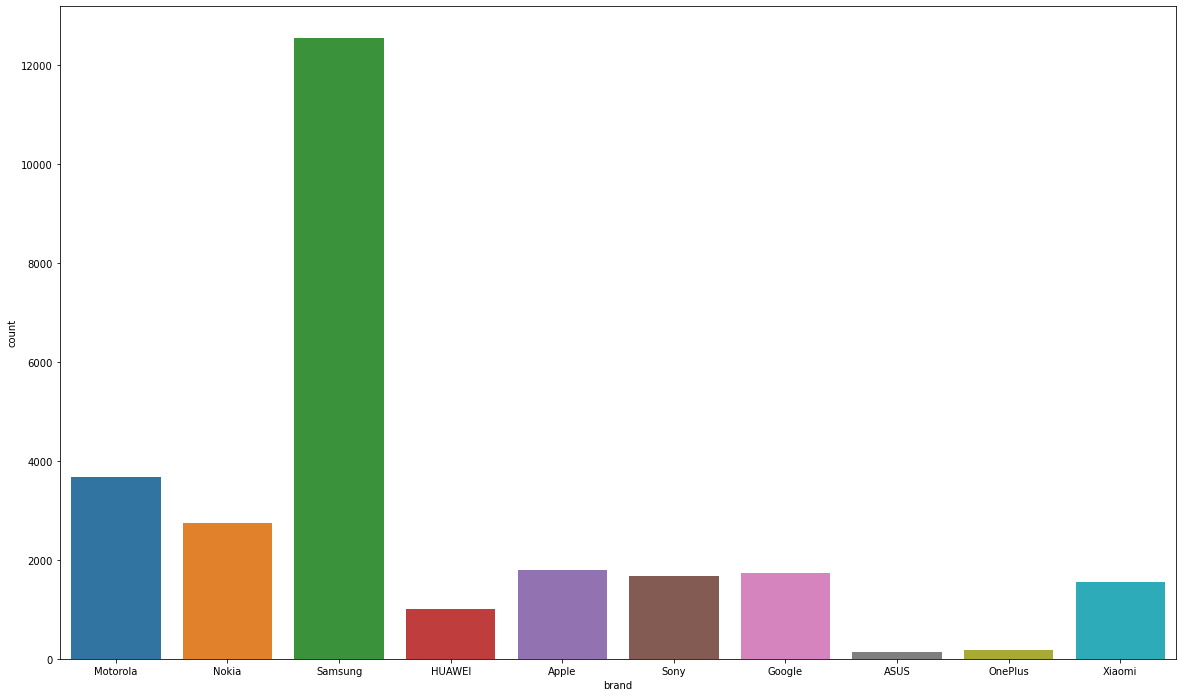

In [11]:
plt.figure(figsize=(20,12))
sns.countplot(x = 'brand', data =data)

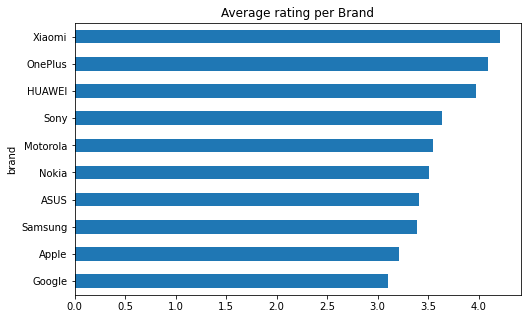

In [12]:
# Average rating per brand
ax = data.groupby("brand").mean()["rating"].sort_values().plot(kind="barh",
                                                                figsize=(8,5), 
                                                                title="Average rating per Brand")
plt.show()

#### Extracting year and month from date

In [13]:
# new data frame which has date and year
new = data["date"].str.split(",", n = 1, expand = True) 
  
# making separate date column from new data frame 
data["Dated"]= new[0] 
  
# making separate year column from new data frame 
data["year"]= new[1] 

data=data.drop(['date'], axis=1)
data.head()

,asin,brand,rating,totalReviews,overall_rating,item_title,body,Dated,year
43,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,This phone isn't kidding when it says military...,May 12,2009
44,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,I bought this phone and found out IDEN phones ...,November 19,2012
49,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,PHONE DID NOT COME WITH A SIM CARD....INFORMAT...,November 25,2012
53,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,Wouldn't know anything about the cell phone I ...,October 18,2009
54,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,For someone needing a very basic phone and ser...,April 7,2010


In [14]:
# Splitting the date 
new1 = data["Dated"].str.split(" ", n = 1, expand = True) 
  
# adding month to the main dataset 
data["month"]= new1[0] 
  
# adding day to the main dataset 
data["day"]= new1[1] 

data=data.drop(['Dated'], axis=1)
data.head()

,asin,brand,rating,totalReviews,overall_rating,item_title,body,year,month,day
43,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,This phone isn't kidding when it says military...,2009,May,12
44,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,I bought this phone and found out IDEN phones ...,2012,November,19
49,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,PHONE DID NOT COME WITH A SIM CARD....INFORMAT...,2012,November,25
53,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,Wouldn't know anything about the cell phone I ...,2009,October,18
54,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,For someone needing a very basic phone and ser...,2010,April,7


#### Ploting reviews over time

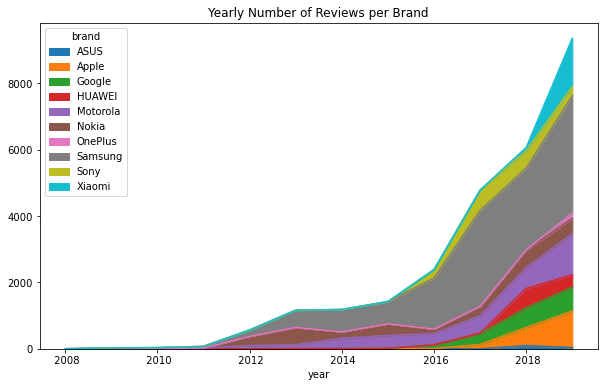

In [15]:

ax = pd.pivot_table(data, 
                    index="year", 
                    columns="brand", 
                    values="asin", 
                    aggfunc="count", 
                    fill_value=0).plot.area(title="Yearly Number of Reviews per Brand", figsize=(10, 6))

From this plot we can concluded that Samsung is the most rated brands, while Xiaomi has the highest average rating.

### Data  Preprocessing

In [16]:
def review_cleaning(text):
   
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [17]:
data['body']=data['body'].apply(lambda x:review_cleaning(x))
data.head()

,asin,brand,rating,totalReviews,overall_rating,item_title,body,year,month,day
43,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,this phone isnt kidding when it says military ...,2009,May,12
44,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,i bought this phone and found out iden phones ...,2012,November,19
49,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,phone did not come with a sim cardinformation ...,2012,November,25
53,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,wouldnt know anything about the cell phone i o...,2009,October,18
54,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,for someone needing a very basic phone and ser...,2010,April,7


In [18]:
#Tokenization of text
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer=ToktokTokenizer()

#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [19]:
#set stopwords to english
from nltk.corpus import stopwords

stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


#Apply function on review column
data['body'] = data['body'].apply(remove_stopwords)
data.head()

{'when', 'isn', "don't", 'after', 'until', 'their', 'further', 'down', 'between', 'this', 'over', 'here', 'and', 'wasn', 's', "weren't", 'ourselves', 'under', 'yourself', 'were', 'an', 'about', 'how', 'only', 'so', 'hasn', 'having', 'd', 'o', 'mightn', "you're", 'don', 'above', 'with', 'have', 'themselves', 'our', 'myself', 'are', 'you', 'before', 'into', 'up', 'we', "hasn't", 'him', 'been', 'as', "she's", 'hers', 'but', 'all', 'wouldn', 'just', 'll', 'theirs', 'aren', 'out', 'more', 'against', 'on', 'these', 'very', 'who', 'where', 'didn', 'for', 'if', "that'll", 'whom', 'be', "needn't", "you've", 'my', 'haven', 'yourselves', "haven't", 'ours', "hadn't", 'herself', 'yours', 'i', 'its', "wasn't", "should've", 'own', 'itself', 'because', 'won', 'doesn', 'each', 'doing', 'in', 'from', 'once', "couldn't", 'your', 'any', 'he', 'both', 'mustn', 'nor', 'they', 'same', 'off', 'shan', "aren't", 'had', "mustn't", 'those', 'below', 'or', 'other', 'weren', "mightn't", 'ma', 'she', 'such', 'throug

,asin,brand,rating,totalReviews,overall_rating,item_title,body,year,month,day
43,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,phone isnt kidding says military specs hole po...,2009,May,12
44,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,bought phone found iden phones sim cards longe...,2012,November,19
49,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,phone come sim cardinformation wouldve liked p...,2012,November,25
53,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,wouldnt know anything cell phone ordered perso...,2009,October,18
54,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,someone needing basic phone services ie email ...,2010,April,7


In [20]:
#Stemming the text

def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Apply function on review column
data['body'] = data['body'].apply(simple_stemmer)
data.head()

,asin,brand,rating,totalReviews,overall_rating,item_title,body,year,month,day
43,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,phone isnt kid say militari spec hole pocket w...,2009,May,12
44,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,bought phone found iden phone sim card longer ...,2012,November,19
49,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,phone come sim cardinform wouldv like phone wo...,2012,November,25
53,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,wouldnt know anyth cell phone order person has...,2009,October,18
54,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,someon need basic phone servic ie email access...,2010,April,7


### Lemmatization

In [21]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [22]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
 

def lemmatize(text):
    lemmatizer = WordNetLemmatizer() 
    text= ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text


data['body'] = data['body'].apply(lemmatize)
print(data['body'])

43       phone isnt kid say militari spec hole pocket w...
44       bought phone found iden phone sim card longer ...
49       phone come sim cardinform wouldv like phone wo...
53       wouldnt know anyth cell phone order person has...
54       someon need basic phone servic ie email access...
                               ...                        
67978    updat star ive use phone daili week gotta say ...
67979    updat like send receiv pictur text regularli m...
67980    love new phone ive die review got mani layer t...
67981    love camera phone screen huge color vibrant pr...
67982    ive xperia user sever year say soni come long ...
Name: body, Length: 27071, dtype: object


### Sentiment Analysis

In [24]:
def f(row):
    
    if row['rating'] == 1.0 or row['rating'] == 2.0:
        val = 'Negative'
    elif row['rating'] == 3.0 or row['rating'] == 4.0 or row['rating'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [25]:

data['sentiment'] = data.apply(f, axis=1)
data.head(10)

,asin,brand,rating,totalReviews,overall_rating,item_title,body,year,month,day,sentiment
43,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,phone isnt kid say militari spec hole pocket w...,2009,May,12,Positive
44,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,bought phone found iden phone sim card longer ...,2012,November,19,Negative
49,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,phone come sim cardinform wouldv like phone wo...,2012,November,25,Positive
53,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,wouldnt know anyth cell phone order person has...,2009,October,18,Negative
54,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,someon need basic phone servic ie email access...,2010,April,7,Positive
55,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,profession recent purchas sanyo juno phone use...,2011,April,13,Negative
57,B001AO4OUC,Motorola,5,21,3.3,Motorola i335 Cell Phone Boost Mobile,phone awesom one boost mobil unlimit plan boug...,2009,August,13,Positive
59,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,find text imposs phone anoth review said scree...,2011,September,1,Negative
60,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,recent ruin work good servic work well spent p...,2010,June,30,Negative
61,B001AO4OUC,Motorola,5,21,3.3,Motorola i335 Cell Phone Boost Mobile,love phone ye would love featur love phone sou...,2009,October,2,Positive


In [26]:
data['sentiment'].value_counts()

Positive    18172
Negative     8899
Name: sentiment, dtype: int64

In [27]:
lb=LabelEncoder()
data['sentiment'] = lb.fit_transform(data['sentiment'])
print(data['sentiment'])

43       1
44       0
49       1
53       0
54       1
        ..
67978    1
67979    1
67980    1
67981    1
67982    1
Name: sentiment, Length: 27071, dtype: int32


In [28]:
    X = data['body']
    y = data['sentiment']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
    
    print(X_train.shape,y_train.shape)
    print(X_test.shape,y_test.shape)
    

(18949,) (18949,)
(8122,) (8122,)


### Word2Vec

In [23]:
from gensim.models import Word2Vec
sentences = data['body']

sentences = [nltk.word_tokenize(sentence) for sentence in sentences]

model = Word2Vec(sentences, min_count=2)
#words = model.wv.vocab

vectors = model.wv['phone']
print(vectors)

[-0.378742   -1.4439931  -0.42353612 -0.954629   -1.1821126   0.5625517
  1.6521842  -0.12181417  0.32594264  0.01848525 -1.0494871  -0.6615018
 -0.36370113  0.5093452   0.8538409   0.70508796 -0.36300275 -0.02432007
  0.2476442  -0.41194162  0.23484191 -0.4046112  -0.43338668 -0.01691144
  0.3407438  -0.20743264 -0.34548447  0.32253644 -0.16643293  0.333058
  1.3291242  -0.72843057  0.76171136 -0.274151   -0.546549   -0.69294435
  1.2085185   0.15242437  0.7864748   1.2803081   0.46973145 -0.7713432
 -0.12542798 -1.3716707  -0.02398741  0.5339408   0.4073013   0.23794213
 -0.19606653  0.5915132  -0.09546093 -0.30081606  1.7875965   0.4266171
 -0.8351899  -0.07052498  1.1150094  -0.96419275 -1.1848425  -0.05740099
  0.39519358 -0.4736721   0.09571246 -0.08887843  1.3616544   0.630708
  0.7371932   0.6474686  -0.57400584 -0.16798131 -0.29146633  0.43967476
  0.2552926   0.5024438   0.68687683 -0.2125194   0.20661707  1.2734767
  1.4955902  -0.7972981  -1.1747508  -1.0868255   0.3696757 

### Bags of words model

It is used to convert text documents to numerical vectors or bag of words.

In [29]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))

#transformed train reviews
cv_train_reviews=cv.fit_transform(X_train)
#transformed test reviews
cv_test_reviews=cv.transform(X_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)


BOW_cv_train: (18949, 910269)
BOW_cv_test: (8122, 910269)


### Term Frequency-Inverse Document Frequency model (TFIDF)

It is used to convert text documents to matrix of tfidf features.

In [30]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

#transformed train reviews
tv_train_reviews=tv.fit_transform(X_train)

#transformed test reviews
tv_test_reviews=tv.transform(X_test)

print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (18949, 910269)
Tfidf_test: (8122, 910269)


### Modelling the dataset

#### Logistic regression model for both bag of words and tfidf features

In [31]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,y_train)
print(lr_bow)

#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,y_train)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


#### Logistic regression model performane on test dataset

In [32]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)

##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 1 0 ... 1 1 0]
[1 1 1 ... 1 1 1]


#### Accuracy of the model

In [33]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(y_test,lr_bow_predict)
print("lr_bow_score :{:.2f}%".format(lr_bow_score*100))

#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(y_test,lr_tfidf_predict)
print("lr_tfidf_score : {:.2f}%".format(lr_tfidf_score*100))

lr_bow_score :70.92%
lr_tfidf_score : 68.09%


#### Classification report

In [34]:
#Classification report for bag of words 
lr_bow_report=classification_report(y_test,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(y_test,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.95      0.09      0.17      2592
    Negative       0.70      1.00      0.82      5530

    accuracy                           0.71      8122
   macro avg       0.83      0.55      0.50      8122
weighted avg       0.78      0.71      0.62      8122

              precision    recall  f1-score   support

    Positive       0.00      0.00      0.00      2592
    Negative       0.68      1.00      0.81      5530

    accuracy                           0.68      8122
   macro avg       0.34      0.50      0.41      8122
weighted avg       0.46      0.68      0.55      8122



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Stochastic gradient descent or Linear support vector machines for bag of words and tfidf features

In [35]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)

#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,y_train)
print(svm_bow)

#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,y_train)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


#### Model performance on test data

In [36]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)

#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[1 1 0 ... 1 1 0]
[1 1 1 ... 1 1 1]


#### Accuracy of the model

In [37]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(y_test,svm_bow_predict)
print("svm_bow_score :{:.2f}%".format(svm_bow_score*100))

#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(y_test,svm_tfidf_predict)
print("svm_tfidf_score :{:.2f}%".format(svm_tfidf_score*100))

svm_bow_score :70.64%
svm_tfidf_score :68.09%


#### Classification report

In [38]:
#Classification report for bag of words 
svm_bow_report=classification_report(y_test,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)

#Classification report for tfidf features
svm_tfidf_report=classification_report(y_test,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.94      0.09      0.16      2592
    Negative       0.70      1.00      0.82      5530

    accuracy                           0.71      8122
   macro avg       0.82      0.54      0.49      8122
weighted avg       0.78      0.71      0.61      8122

              precision    recall  f1-score   support

    Positive       0.00      0.00      0.00      2592
    Negative       0.68      1.00      0.81      5530

    accuracy                           0.68      8122
   macro avg       0.34      0.50      0.41      8122
weighted avg       0.46      0.68      0.55      8122



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Multinomial Naive Bayes for bag of words and tfidf features

In [39]:
#training the model
mnb=MultinomialNB()

#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,y_train)


#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,y_train)


#### Model performance on test data


In [40]:

#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)

#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[1 1 0 ... 1 1 0]
[1 1 1 ... 1 1 0]


#### Accuracy of the model

In [41]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(y_test,mnb_bow_predict)
print("mnb_bow_score :{:.2f}%".format(mnb_bow_score*100))

#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(y_test,mnb_tfidf_predict)
print("mnb_tfidf_score :{:.2f}%".format(mnb_tfidf_score*100))

mnb_bow_score :73.09%
mnb_tfidf_score :70.67%


#### Classification report

In [42]:
#Classification report for bag of words 
mnb_bow_report=classification_report(y_test,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)

#Classification report for tfidf features
mnb_tfidf_report=classification_report(y_test,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.85      0.19      0.31      2592
    Negative       0.72      0.98      0.83      5530

    accuracy                           0.73      8122
   macro avg       0.78      0.59      0.57      8122
weighted avg       0.76      0.73      0.67      8122

              precision    recall  f1-score   support

    Positive       0.99      0.08      0.15      2592
    Negative       0.70      1.00      0.82      5530

    accuracy                           0.71      8122
   macro avg       0.84      0.54      0.49      8122
weighted avg       0.79      0.71      0.61      8122



#### Conclusion

We can observed that multinomial naive bayes model performing well compared to logistic regression and linear support vector machines.

## Sentimental Analysis using Vader

There are two common approaches for text sentiment analysis: the lexical method and the machine learning methhod.

The lexcial method maps the new text to a pre-defined "dictionary of sentiment". VADER is one example of such method. Wtihe VADER, the sentiment score of a sentence is the normalised sum of sentiment scores of each word in that sentence.

In [43]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [44]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [45]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(df['body'].iloc[11])

{'neg': 0.0, 'neu': 0.872, 'pos': 0.128, 'compound': 0.2263}

In [46]:
dfs = df.copy()
dfs = dfs[['asin', 'brand', 'rating','overall_rating','title', 'item_title', 'body']]
dfs.head()

,asin,brand,rating,overall_rating,title,item_title,body
43,B001AO4OUC,Motorola,4,3.3,tough little phone,Motorola i335 Cell Phone Boost Mobile,This phone isn't kidding when it says military...
44,B001AO4OUC,Motorola,1,3.3,Boost Mobile no Longer allows IDEN service,Motorola i335 Cell Phone Boost Mobile,I bought this phone and found out IDEN phones ...
49,B001AO4OUC,Motorola,4,3.3,SIM CARD,Motorola i335 Cell Phone Boost Mobile,PHONE DID NOT COME WITH A SIM CARD....INFORMAT...
53,B001AO4OUC,Motorola,1,3.3,Cell,Motorola i335 Cell Phone Boost Mobile,Wouldn't know anything about the cell phone I ...
54,B001AO4OUC,Motorola,4,3.3,For a basic phone quite good,Motorola i335 Cell Phone Boost Mobile,For someone needing a very basic phone and ser...


In [47]:
def review_cleaning(text):

    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [48]:
dfs['body']=dfs['body'].apply(lambda x:review_cleaning(x))
dfs['title']=dfs['title'].apply(lambda x:review_cleaning(x))
dfs.head()

,asin,brand,rating,overall_rating,title,item_title,body
43,B001AO4OUC,Motorola,4,3.3,tough little phone,Motorola i335 Cell Phone Boost Mobile,this phone isnt kidding when it says military ...
44,B001AO4OUC,Motorola,1,3.3,boost mobile no longer allows iden service,Motorola i335 Cell Phone Boost Mobile,i bought this phone and found out iden phones ...
49,B001AO4OUC,Motorola,4,3.3,sim card,Motorola i335 Cell Phone Boost Mobile,phone did not come with a sim cardinformation ...
53,B001AO4OUC,Motorola,1,3.3,cell,Motorola i335 Cell Phone Boost Mobile,wouldnt know anything about the cell phone i o...
54,B001AO4OUC,Motorola,4,3.3,for a basic phone quite good,Motorola i335 Cell Phone Boost Mobile,for someone needing a very basic phone and ser...


In [49]:
dfs['title_score'] = dfs['title'].apply(lambda x: sid.polarity_scores(x))
dfs.head()

,asin,brand,rating,overall_rating,title,item_title,body,title_score
43,B001AO4OUC,Motorola,4,3.3,tough little phone,Motorola i335 Cell Phone Boost Mobile,this phone isnt kidding when it says military ...,"{'neg': 0.429, 'neu': 0.571, 'pos': 0.0, 'comp..."
44,B001AO4OUC,Motorola,1,3.3,boost mobile no longer allows iden service,Motorola i335 Cell Phone Boost Mobile,i bought this phone and found out iden phones ...,"{'neg': 0.222, 'neu': 0.505, 'pos': 0.273, 'co..."
49,B001AO4OUC,Motorola,4,3.3,sim card,Motorola i335 Cell Phone Boost Mobile,phone did not come with a sim cardinformation ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
53,B001AO4OUC,Motorola,1,3.3,cell,Motorola i335 Cell Phone Boost Mobile,wouldnt know anything about the cell phone i o...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
54,B001AO4OUC,Motorola,4,3.3,for a basic phone quite good,Motorola i335 Cell Phone Boost Mobile,for someone needing a very basic phone and ser...,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp..."


In [50]:
dfs['title_compound'] = dfs['title_score'].apply(lambda x: x['compound'])
dfs.head()

,asin,brand,rating,overall_rating,title,item_title,body,title_score,title_compound
43,B001AO4OUC,Motorola,4,3.3,tough little phone,Motorola i335 Cell Phone Boost Mobile,this phone isnt kidding when it says military ...,"{'neg': 0.429, 'neu': 0.571, 'pos': 0.0, 'comp...",-0.1280
44,B001AO4OUC,Motorola,1,3.3,boost mobile no longer allows iden service,Motorola i335 Cell Phone Boost Mobile,i bought this phone and found out iden phones ...,"{'neg': 0.222, 'neu': 0.505, 'pos': 0.273, 'co...",0.1280
49,B001AO4OUC,Motorola,4,3.3,sim card,Motorola i335 Cell Phone Boost Mobile,phone did not come with a sim cardinformation ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
53,B001AO4OUC,Motorola,1,3.3,cell,Motorola i335 Cell Phone Boost Mobile,wouldnt know anything about the cell phone i o...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
54,B001AO4OUC,Motorola,4,3.3,for a basic phone quite good,Motorola i335 Cell Phone Boost Mobile,for someone needing a very basic phone and ser...,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",0.4927


In [51]:
  def f(dfs):
        
    if dfs['title_compound'] >= 0.05 :
       value = "Positive"
 
    elif dfs['title_compound'] <= - 0.05 :
      value = "Negative"
 
    else :
       value = "Neutral"
    
    return value

dfs['title_sentiment'] = dfs.apply(f, axis=1)
dfs.head()


,asin,brand,rating,overall_rating,title,item_title,body,title_score,title_compound,title_sentiment
43,B001AO4OUC,Motorola,4,3.3,tough little phone,Motorola i335 Cell Phone Boost Mobile,this phone isnt kidding when it says military ...,"{'neg': 0.429, 'neu': 0.571, 'pos': 0.0, 'comp...",-0.1280,Negative
44,B001AO4OUC,Motorola,1,3.3,boost mobile no longer allows iden service,Motorola i335 Cell Phone Boost Mobile,i bought this phone and found out iden phones ...,"{'neg': 0.222, 'neu': 0.505, 'pos': 0.273, 'co...",0.1280,Positive
49,B001AO4OUC,Motorola,4,3.3,sim card,Motorola i335 Cell Phone Boost Mobile,phone did not come with a sim cardinformation ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
53,B001AO4OUC,Motorola,1,3.3,cell,Motorola i335 Cell Phone Boost Mobile,wouldnt know anything about the cell phone i o...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
54,B001AO4OUC,Motorola,4,3.3,for a basic phone quite good,Motorola i335 Cell Phone Boost Mobile,for someone needing a very basic phone and ser...,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",0.4927,Positive


In [52]:
dfs['title_sentiment'].value_counts()

Positive    12605
Neutral      9876
Negative     4590
Name: title_sentiment, dtype: int64

In [53]:
dfs['body_score'] = dfs['body'].apply(lambda x: sid.polarity_scores(x))
dfs.head()

,asin,brand,rating,overall_rating,title,item_title,body,title_score,title_compound,title_sentiment,body_score
43,B001AO4OUC,Motorola,4,3.3,tough little phone,Motorola i335 Cell Phone Boost Mobile,this phone isnt kidding when it says military ...,"{'neg': 0.429, 'neu': 0.571, 'pos': 0.0, 'comp...",-0.1280,Negative,"{'neg': 0.077, 'neu': 0.865, 'pos': 0.057, 'co..."
44,B001AO4OUC,Motorola,1,3.3,boost mobile no longer allows iden service,Motorola i335 Cell Phone Boost Mobile,i bought this phone and found out iden phones ...,"{'neg': 0.222, 'neu': 0.505, 'pos': 0.273, 'co...",0.1280,Positive,"{'neg': 0.058, 'neu': 0.871, 'pos': 0.071, 'co..."
49,B001AO4OUC,Motorola,4,3.3,sim card,Motorola i335 Cell Phone Boost Mobile,phone did not come with a sim cardinformation ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"{'neg': 0.139, 'neu': 0.723, 'pos': 0.138, 'co..."
53,B001AO4OUC,Motorola,1,3.3,cell,Motorola i335 Cell Phone Boost Mobile,wouldnt know anything about the cell phone i o...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"{'neg': 0.059, 'neu': 0.896, 'pos': 0.045, 'co..."
54,B001AO4OUC,Motorola,4,3.3,for a basic phone quite good,Motorola i335 Cell Phone Boost Mobile,for someone needing a very basic phone and ser...,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",0.4927,Positive,"{'neg': 0.074, 'neu': 0.841, 'pos': 0.085, 'co..."


In [54]:
dfs['body_compound'] = dfs['body_score'].apply(lambda x: x['compound'])
dfs.head()

,asin,brand,rating,overall_rating,title,item_title,body,title_score,title_compound,title_sentiment,body_score,body_compound
43,B001AO4OUC,Motorola,4,3.3,tough little phone,Motorola i335 Cell Phone Boost Mobile,this phone isnt kidding when it says military ...,"{'neg': 0.429, 'neu': 0.571, 'pos': 0.0, 'comp...",-0.1280,Negative,"{'neg': 0.077, 'neu': 0.865, 'pos': 0.057, 'co...",-0.7557
44,B001AO4OUC,Motorola,1,3.3,boost mobile no longer allows iden service,Motorola i335 Cell Phone Boost Mobile,i bought this phone and found out iden phones ...,"{'neg': 0.222, 'neu': 0.505, 'pos': 0.273, 'co...",0.1280,Positive,"{'neg': 0.058, 'neu': 0.871, 'pos': 0.071, 'co...",0.1280
49,B001AO4OUC,Motorola,4,3.3,sim card,Motorola i335 Cell Phone Boost Mobile,phone did not come with a sim cardinformation ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"{'neg': 0.139, 'neu': 0.723, 'pos': 0.138, 'co...",-0.2708
53,B001AO4OUC,Motorola,1,3.3,cell,Motorola i335 Cell Phone Boost Mobile,wouldnt know anything about the cell phone i o...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"{'neg': 0.059, 'neu': 0.896, 'pos': 0.045, 'co...",-0.1426
54,B001AO4OUC,Motorola,4,3.3,for a basic phone quite good,Motorola i335 Cell Phone Boost Mobile,for someone needing a very basic phone and ser...,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",0.4927,Positive,"{'neg': 0.074, 'neu': 0.841, 'pos': 0.085, 'co...",0.5940


In [55]:
  def f(dfs):
        
    if dfs['body_compound'] >= 0.05 :
       value = "Positive"
 
    elif dfs['body_compound'] <= - 0.05 :
      value = "Negative"
 
    else :
       value = "Neutral"
    
    return value
 

In [56]:
dfs['body_sentiment'] = dfs.apply(f, axis=1)
dfs.head()

,asin,brand,rating,overall_rating,title,item_title,body,title_score,title_compound,title_sentiment,body_score,body_compound,body_sentiment
43,B001AO4OUC,Motorola,4,3.3,tough little phone,Motorola i335 Cell Phone Boost Mobile,this phone isnt kidding when it says military ...,"{'neg': 0.429, 'neu': 0.571, 'pos': 0.0, 'comp...",-0.1280,Negative,"{'neg': 0.077, 'neu': 0.865, 'pos': 0.057, 'co...",-0.7557,Negative
44,B001AO4OUC,Motorola,1,3.3,boost mobile no longer allows iden service,Motorola i335 Cell Phone Boost Mobile,i bought this phone and found out iden phones ...,"{'neg': 0.222, 'neu': 0.505, 'pos': 0.273, 'co...",0.1280,Positive,"{'neg': 0.058, 'neu': 0.871, 'pos': 0.071, 'co...",0.1280,Positive
49,B001AO4OUC,Motorola,4,3.3,sim card,Motorola i335 Cell Phone Boost Mobile,phone did not come with a sim cardinformation ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"{'neg': 0.139, 'neu': 0.723, 'pos': 0.138, 'co...",-0.2708,Negative
53,B001AO4OUC,Motorola,1,3.3,cell,Motorola i335 Cell Phone Boost Mobile,wouldnt know anything about the cell phone i o...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"{'neg': 0.059, 'neu': 0.896, 'pos': 0.045, 'co...",-0.1426,Negative
54,B001AO4OUC,Motorola,4,3.3,for a basic phone quite good,Motorola i335 Cell Phone Boost Mobile,for someone needing a very basic phone and ser...,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",0.4927,Positive,"{'neg': 0.074, 'neu': 0.841, 'pos': 0.085, 'co...",0.5940,Positive


In [57]:
dfs['body_sentiment'].value_counts()

Positive    18047
Negative     6469
Neutral      2555
Name: body_sentiment, dtype: int64

Text(0.5, 1.0, 'Comments sentiment analysis')

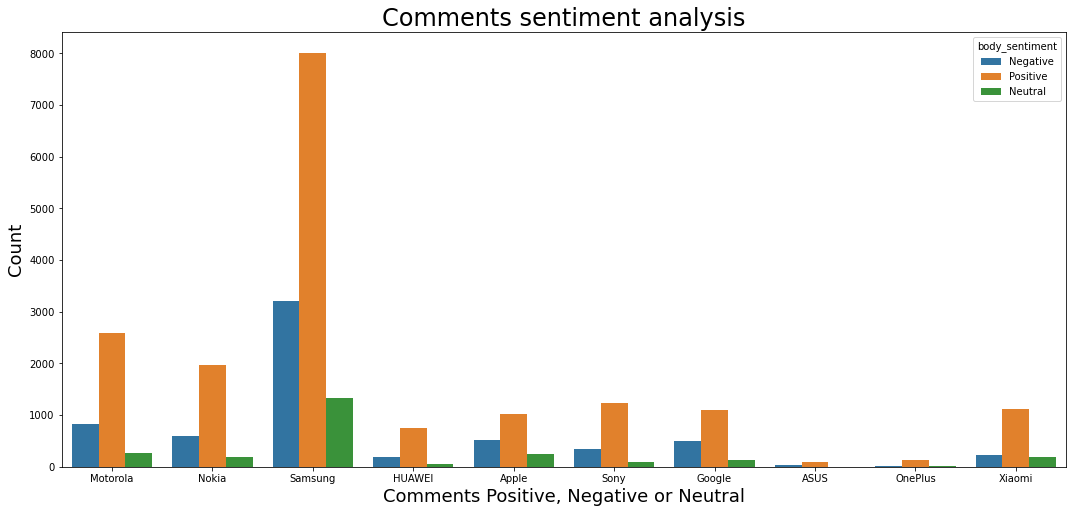

In [58]:
plt.figure(figsize=(18,8))
sns.countplot(x = 'brand', hue = 'body_sentiment', data = dfs)
plt.xlabel('Comments Positive, Negative or Neutral', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
plt.title('Comments sentiment analysis', fontsize = 24)

Text(0.5, 1.0, 'Title sentiment analysis')

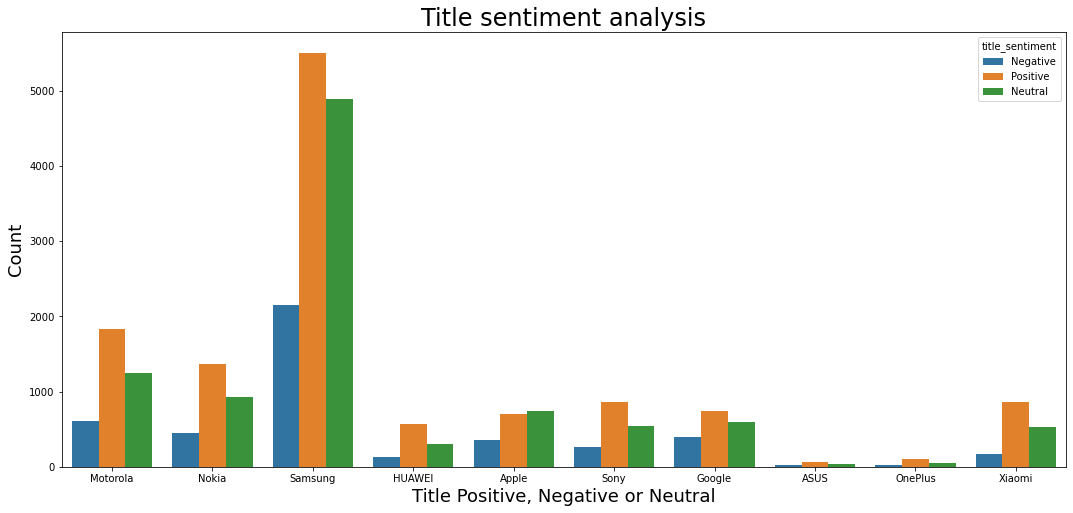

In [59]:
plt.figure(figsize=(18,8))
sns.countplot(x = 'brand', hue = 'title_sentiment', data = dfs)
plt.xlabel('Title Positive, Negative or Neutral', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
plt.title('Title sentiment analysis', fontsize = 24)

In [60]:
print(classification_report(dfs['title_sentiment'], dfs['body_sentiment']))

              precision    recall  f1-score   support

    Negative       0.40      0.56      0.47      4590
     Neutral       0.72      0.19      0.29      9876
    Positive       0.61      0.87      0.72     12605

    accuracy                           0.57     27071
   macro avg       0.57      0.54      0.49     27071
weighted avg       0.61      0.57      0.52     27071



#### Conclusion for sentiment analysis using vader

As a result, we can conclude that the majority of the reviews and titles are positive, and the correlation between the rating and the sentiment of the reviews is also favorable.

## Word Cloud

In [61]:
reviews = df.copy()

In [62]:
reviews["positivity"] = reviews["rating"].apply(lambda x: 1 if x>3 else(0 if x==3 else -1))

In [63]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english'))
punc = set(string.punctuation)
keywords = reviews["brand"].apply(lambda x: x.lower()).unique().tolist()
keywords.append("phone")
lemma = WordNetLemmatizer()
def clean_text(text):
    
    text = text.lower()
    
    wordList = text.split()
    
    wordList = ["".join(x for x in word if (x=="'")|(x not in punc)) for word in wordList]
   
    wordList = [word for word in wordList if word not in stop]
   
    wordList = [word for word in wordList if word not in keywords]
    
    wordList = [lemma.lemmatize(word) for word in wordList]
    return " ".join(wordList)


In [64]:
reviews["body"] = reviews["body"].astype("str")
reviews["clean_text"] = reviews["body"].apply(clean_text)

##### Creating wordcloud

In [65]:
def word_freq_dict(text):
  
    wordList = text.split()
  
    wordFreqDict = {word: wordList.count(word) for word in wordList}
    
    return wordFreqDict


##### Brand subsets

In [66]:

apple = reviews[reviews["brand"]=="Apple"].sort_values(by=["date"], ascending=False)
samsung = reviews[reviews["brand"]=="Samsung"].sort_values(by=["date"], ascending=False)


In [67]:
from wordcloud import WordCloud, ImageColorGenerator

# Function to create a wordcloud from dictionary of word frequency
def wordcloud_from_frequency(word_freq_dict, title, figure_size=(10, 6)):
    wordcloud.generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

In [68]:
# Function to plot top10 positive words and top10 negative words in a grouped bar plot (from dictionaries)

def topn_wordfreq_bar_both(pos_word_freq_dict, neg_word_freq_dict, pos_num_doc, neg_num_doc, topn, title, palette, height=6, aspect=2):
    # Transforming positive word frequency into DF
    df_pos = pd.DataFrame.from_dict(pos_word_freq_dict, orient="index").sort_values(by=0, ascending=False).head(topn)
    df_pos.columns = ["frequency"]
    df_pos["frequency"] = df_pos["frequency"] / pos_num_doc
    df_pos["label"] = "Positive"
    
    # Transforming negative word frequency into DF
    df_neg = pd.DataFrame.from_dict(neg_word_freq_dict, orient="index").sort_values(by=0, ascending=False).head(topn)
    df_neg.columns = ["frequency"]
    df_neg["frequency"] = df_neg["frequency"] / neg_num_doc
    df_neg["label"] = "Negative"
    
    # Append two dataframes
    df_append = df_pos.append(df_neg)
    df_append.reset_index(inplace=True)
    # Plot
    sns.catplot(x="index", y="frequency", hue="label", data=df_append, 
                kind="bar",
                palette=palette,
                height=height, aspect=aspect, 
                legend_out=False)
    plt.title(title)
    plt.show()

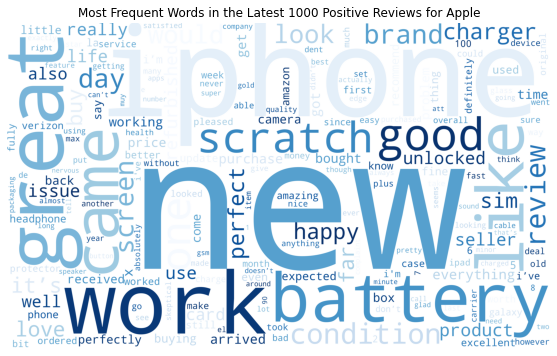

In [69]:
# Wordclouds for 1000 reviews for Apple

apple_pos = " ".join(apple[apple["positivity"]==1]["clean_text"][0:1000])
apple_pos_word_freq = word_freq_dict(apple_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="white")
wordcloud_from_frequency(apple_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Apple")

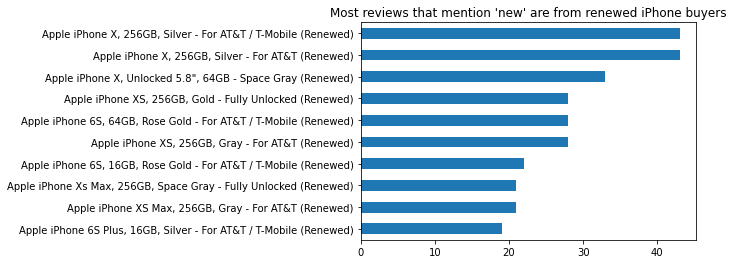

In [70]:
apple[apple["clean_text"].apply(lambda x: "new" in x)]["item_title"].value_counts().sort_values(ascending=True).tail(10).plot(kind="barh")
plt.title("Most reviews that mention 'new' are from renewed iPhone buyers")
plt.show()

In [71]:
apple["renewed"] = apple["item_title"].apply(lambda x: ("Renewed" in x) | ("Reburshied" in x))
print("{0: 0.1%} iPhones that were sold on Amazon are renewed/reburshied.".format(apple["renewed"].sum() / len(apple["renewed"])))

 99.9% iPhones that were sold on Amazon are renewed/reburshied.


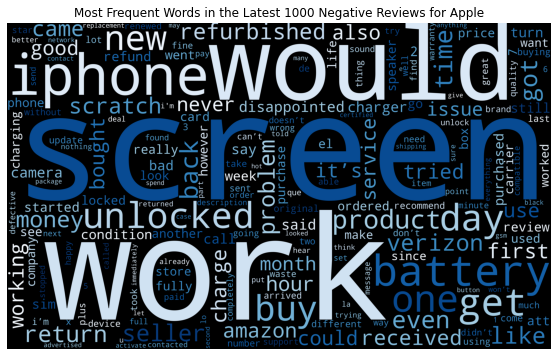

In [72]:
apple_neg = " ".join(apple[apple["positivity"]==-1]["clean_text"][0:1000])
apple_neg_word_freq = word_freq_dict(apple_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="black")
wordcloud_from_frequency(apple_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Apple")

C:\Users\user\AppData\Local\Temp\ipykernel_6012\515505373.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_append = df_pos.append(df_neg)


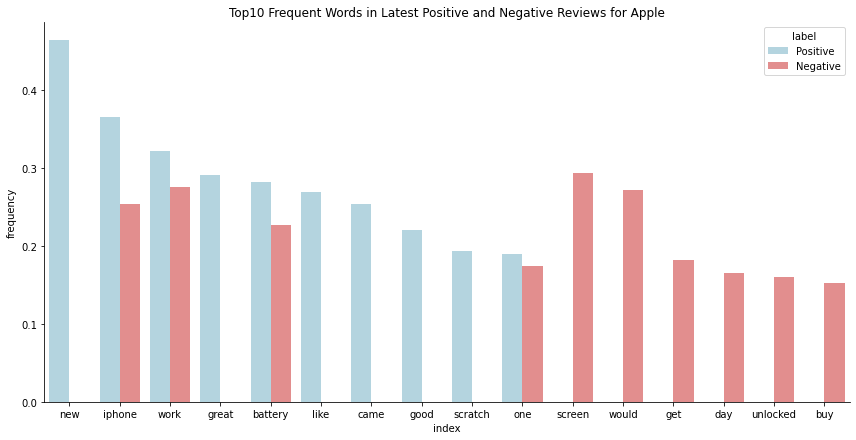

In [73]:
topn_wordfreq_bar_both(apple_pos_word_freq, apple_neg_word_freq, 
                       min(sum(apple["positivity"]==1), 1000), 
                       min(sum(apple["positivity"]==-1), 1000), 
                       10, 
                       "Top10 Frequent Words in Latest Positive and Negative Reviews for Apple", 
                       ["lightblue", "lightcoral"], 
                       height=6, aspect=2)

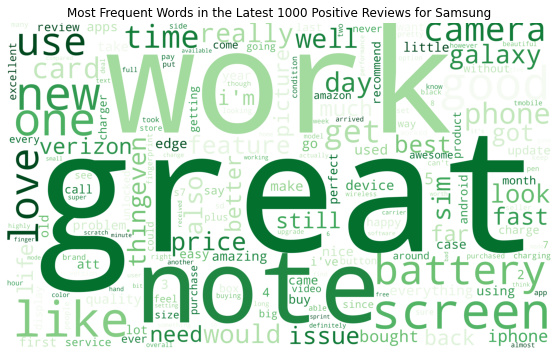

In [74]:
# Wordclouds for 1000 reviews for Samsung

samsung_pos = " ".join(samsung[samsung["positivity"]==1]["clean_text"][0:1000])
samsung_pos_word_freq = word_freq_dict(samsung_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Greens",
                      background_color="white")
wordcloud_from_frequency(samsung_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Samsung")

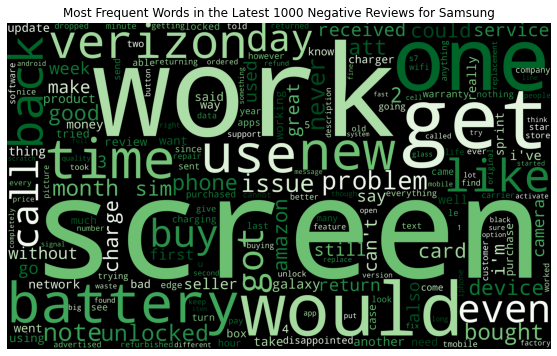

In [75]:
samsung_neg = " ".join(samsung[samsung["positivity"]==-1]["clean_text"][0:1000])
samsung_neg_word_freq = word_freq_dict(samsung_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Greens",
                      background_color="black")
wordcloud_from_frequency(samsung_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Samsung")


C:\Users\user\AppData\Local\Temp\ipykernel_6012\515505373.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_append = df_pos.append(df_neg)


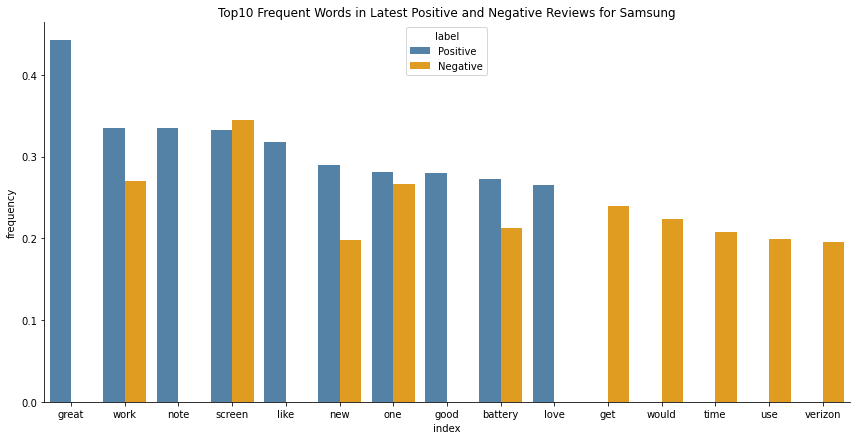

In [76]:
topn_wordfreq_bar_both(samsung_pos_word_freq, samsung_neg_word_freq, 
                       min(sum(samsung["positivity"]==1), 1000), 
                       min(sum(samsung["positivity"]==-1), 1000), 
                       10, 
                       "Top10 Frequent Words in Latest Positive and Negative Reviews for Samsung", 
                       ["steelblue", "orange"], 
                       height=6, aspect=2)

The visulisations above show that:

The most important considerations for cell phone buyers are battery health and screen condition.

The majority of iPhones sold on Amazon are renewed/refurbished. Apple customers are satisfied if their purchases are in (near)    new condition, and they usually complain if there is a scratch on the screen or the battery health is poor.

Samsung buyers are generally satisfied with the overall performance of their purchases, but they have complained about the        screen. Some customers also complained about unlocked phones sold by carriers.